In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_colwidth', None)
import re
import csv
from skimpy import skim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib

In [2]:
data = pd.read_csv(r'C:\Users\USER\Desktop\Supplementary Data\laptop_task\laptop_details.csv')
data.head()

,Product,Rating,MRP,Feature
0,Lenovo IdeaPad 3 Core i3 11th Gen - (8 GB/256 GB SSD/Windows 11 Home) 14ITL05 Thin and Light Laptop,4.2,"₹36,990",Intel Core i3 Processor (11th Gen)8 GB DDR4 RAM64 bit Windows 11 Operating System256 GB SSD35.56 cm (14 inch) DisplayOffice Home and Student 20212 Year Onsite�Warranty
1,Lenovo IdeaPad 3 Core i3 11th Gen - (8 GB/512 GB SSD/Windows 11 Home) 82H801L7IN | 82H802FJIN | 82H802...,4.2,"₹39,990",Intel Core i3 Processor (11th Gen)8 GB DDR4 RAM64 bit Windows 11 Operating System512 GB SSD39.62 cm (15.6 inch) DisplayOffice Home and Student 20212 Year Onsite�Warranty
2,ASUS VivoBook 15 (2022) Core i3 10th Gen - (8 GB/512 GB SSD/Windows 11 Home) X515JA-EJ362WS | X515JA-E...,4.3,"₹32,990",Intel Core i3 Processor (10th Gen)8 GB DDR4 RAM64 bit Windows 11 Operating System512 GB SSD39.62 cm (15.6 inch) DisplayOffice Home and Student 20211 Year Onsite Warranty
3,HP Pavilion Ryzen 5 Hexa Core AMD R5-5600H - (8 GB/512 GB SSD/Windows 10/4 GB Graphics/NVIDIA GeForce ...,4.4,"₹49,990","AMD Ryzen 5 Hexa Core Processor8 GB DDR4 RAM64 bit Windows 10 Operating System512 GB SSD39.62 cm (15.6 inch) DisplayHP Documentation, HP e-service, HP BIOS Recovery, HP SSRM, HP Smart, HP Jumpstarts1 Year Onsite Warranty"
4,ASUS TUF Gaming F15 Core i5 10th Gen - (8 GB/512 GB SSD/Windows 11 Home/4 GB Graphics/NVIDIA GeForce G...,4.4,"₹49,990",Intel Core i5 Processor (10th Gen)8 GB DDR4 RAMWindows 11 Operating System512 GB SSD39.62 cm (15.6 inch) Display1 Year Onsite Warranty


In [3]:
df = data.copy()

In [4]:
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Product  720 non-null    object 
 1   Rating   581 non-null    float64
 2   MRP      720 non-null    object 
 3   Feature  720 non-null    object 
dtypes: float64(1), object(3)
memory usage: 22.6+ KB


In [5]:
# df.isna().sum()

Product      0
Rating     139
MRP          0
Feature      0
dtype: int64

## Feature Engineering
Since, this is mainly a text data, we will use the regex function to clean the data.
We will create new features such as Ram size, Ram type, Processor, Storage type, os from the poducts and feature table

In [4]:
def extract_features(row):
    product = row['Product']
    feature = row['Feature']
    
    ram_size = re.findall(r'(\d+) ?(?:GB|TB)', feature)
    ram_size = ram_size[0] + ' GB' if ram_size else None
    
    ram_type = re.findall(r'(?:LP)?DDR\d\S*|Unified\sMemory', feature)
    ram_type = ram_type[0] if ram_type else None
    
    processor = re.findall(r'(?:AMD|Intel|M1|Qualcomm|Apple)[\s\w]+Processor', feature)
    processor = processor[0] if processor else None

    storage = re.findall(r'[\d]+\s(?:GB|TB)\s(?:HDD|SSD|EMMC)', product)
    storage = storage[0] if storage else None
    
    os = re.findall(r'(Windows (?:10|11)|Mac OS|Linux|DOS|Chrome)[\s\w]*Operating System', feature)
    os = os[0] if os else None

    display = re.findall(r'\d+(?:\.\d+)?\s*(?:cm|inch)\s*(?:\(|:)?\s*\d+(?:\.\d+)?\s*(?:cm|inch)?', feature)
    display = display[0] if display else None
    
    brand = re.findall(r'^\w+', product)
    brand = brand[0] if brand else None
    
    return pd.Series([ram_size, ram_type, processor, storage, os, display, brand], 
                     index=['Ram Size', 'Ram Type', 'Processor', 'Storage', 'OS', 'Display', 'Brand'])

df[['Ram Size', 'Ram Type', 'Processor', 'Storage', 'OS', 'Display', 'Brand']] = df.apply(extract_features, axis=1)

In [7]:
# df.isna().sum()

Product        0
Rating       139
MRP            0
Feature        0
Ram Size       0
Ram Type       0
Processor      0
Storage        0
OS             0
Display        0
Brand          0
dtype: int64

In [8]:
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Product    720 non-null    object 
 1   Rating     581 non-null    float64
 2   MRP        720 non-null    object 
 3   Feature    720 non-null    object 
 4   Ram Size   720 non-null    object 
 5   Ram Type   720 non-null    object 
 6   Processor  720 non-null    object 
 7   Storage    720 non-null    object 
 8   OS         720 non-null    object 
 9   Display    720 non-null    object 
 10  Brand      720 non-null    object 
dtypes: float64(1), object(10)
memory usage: 62.0+ KB


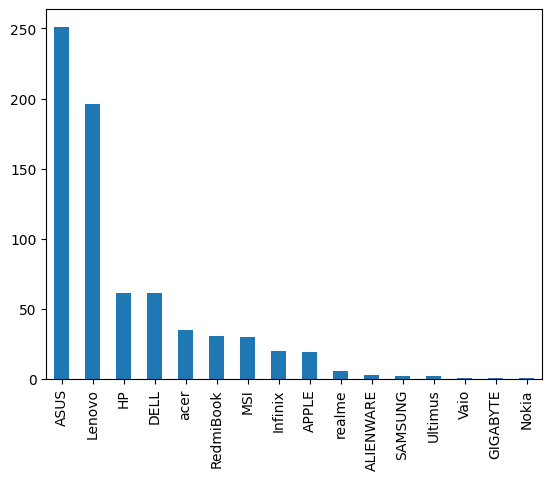

In [9]:
# df.Brand.value_counts().plot(kind='bar');

In [10]:
# df.columns

Index(['Product', 'Rating', 'MRP', 'Feature', 'Ram Size', 'Ram Type',
       'Processor', 'Storage', 'OS', 'Display', 'Brand'],
      dtype='object')

In [11]:
# # print(df['OS'].unique())
# print(df['OS'].nunique())
# print(type(df['OS'][0]))

# print('******************************')

# # print(df['Ram Type'].unique())
# print(df['Ram Type'].nunique())
# print(type(df['Ram Type'][0]))

# print('******************************')

# # print(df['Ram Size'].unique())
# print(df['Ram Size'].nunique())
# print(type(df['Ram Size'][0]))

# print('******************************')

# # print(df['Processor'].unique())
# print(df['Processor'].nunique())
# print(type(df['Processor'][0]))

# print('******************************')

# # print(df['Storage'].unique())
# print(df['Storage'].nunique())
# print(type(df['Storage'][0]))


# print('******************************')

# # print(df['Display'].unique())
# print(df['Display'].nunique())
# print(type(df['Display'][0]))

# print('******************************')

# # print(df['Brand'].unique())
# print(df['Brand'].nunique())
# print(type(df['Brand'][0]))

5
<class 'str'>
******************************
8
<class 'str'>
******************************
5
<class 'str'>
******************************
26
<class 'str'>
******************************
10
<class 'str'>
******************************
26
<class 'str'>
******************************
16
<class 'str'>


In [5]:
## Data Cleaning
df.MRP = df.MRP.apply(lambda x : x.replace('₹', '').replace(',', '')).astype(float)
df.drop(df.columns[[0, 1, 3, 10]], axis=1, inplace=True)
df.head(2)

,MRP,Ram Size,Ram Type,Processor,Storage,OS,Display
0,36990.0,8 GB,DDR4,Intel Core i3 Processor,256 GB SSD,Windows 11,35.56 cm (14 inch
1,39990.0,8 GB,DDR4,Intel Core i3 Processor,512 GB SSD,Windows 11,39.62 cm (15.6 inch


## Data Cleaning

In [6]:
df['Ram Type'] = df['Ram Type'].str.replace('DDR4,','DDR4')

In [11]:
## Rename the column names
new_column_names = {'MRP': 'price',
                    'Ram Size': 'ram_size',
                    'Ram Type': 'ram_type',
                    'Processor': 'processor',
                    'Storage': 'storage',
                    'OS': 'os',
                    'Display': 'display',
                    'Brand': 'brand'}
df = df.rename(columns=new_column_names)

In [12]:
# this extracts the last word in each value, as the storage type
df['storage_type'] = df.storage.apply(lambda x: x.split()[-1])

# using the split function, join the first 2 element
df['storage'] = df.storage.apply(lambda x: " ".join(x.split()[:2]))

## Visualization

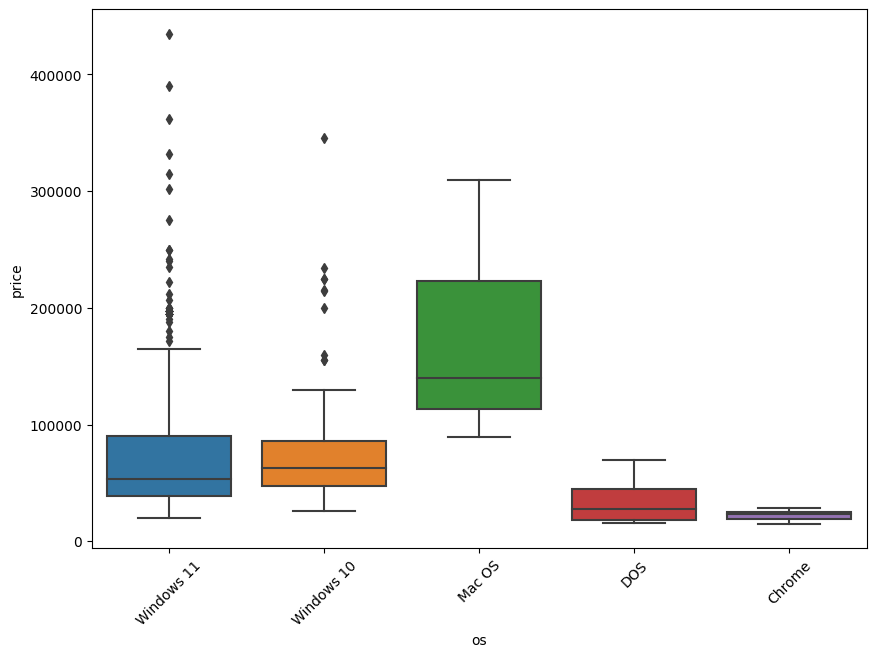

In [16]:
# plt.figure(figsize=(10, 7))
# ax = sns.boxplot(x = df.os, y = df.price)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

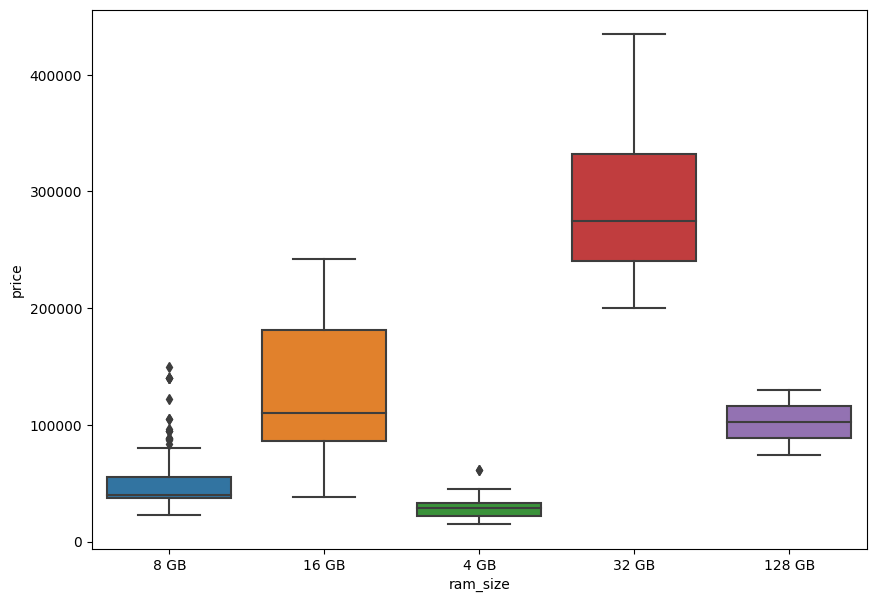

In [17]:
# plt.figure(figsize=(10, 7))
# sns.boxplot(x = df.ram_size, y = df.price);

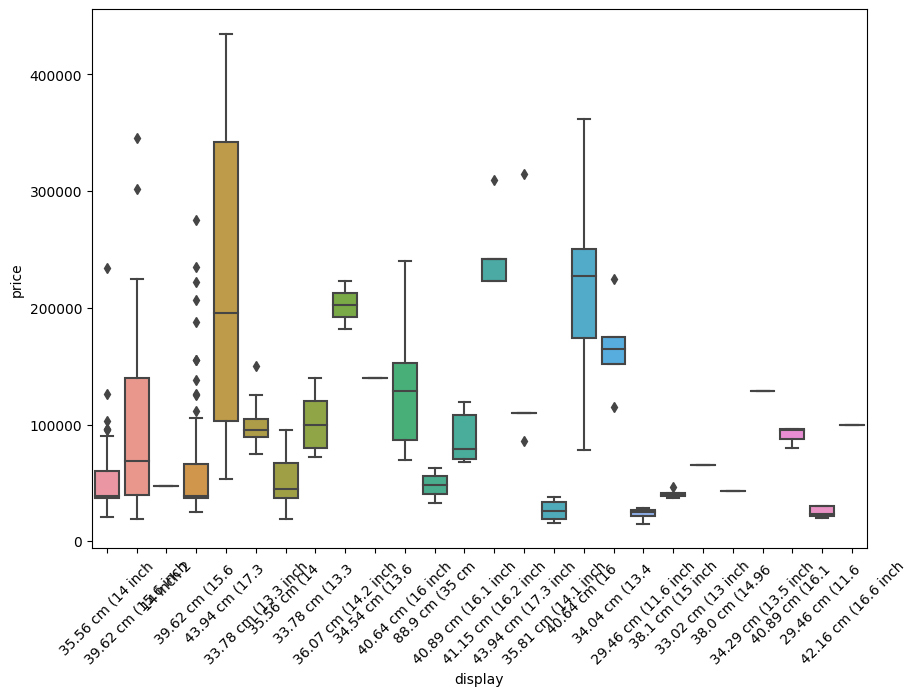

In [18]:
# plt.figure(figsize=(10, 7))
# ax = sns.boxplot(x = df.display, y = df.price)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

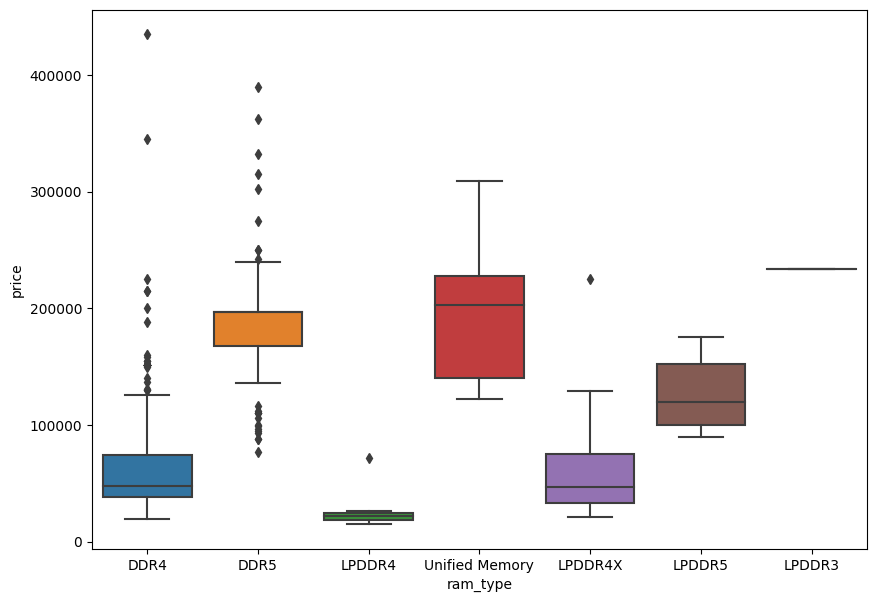

In [19]:
# plt.figure(figsize=(10, 7))
# sns.boxplot(x = df.ram_type, y = df.price);

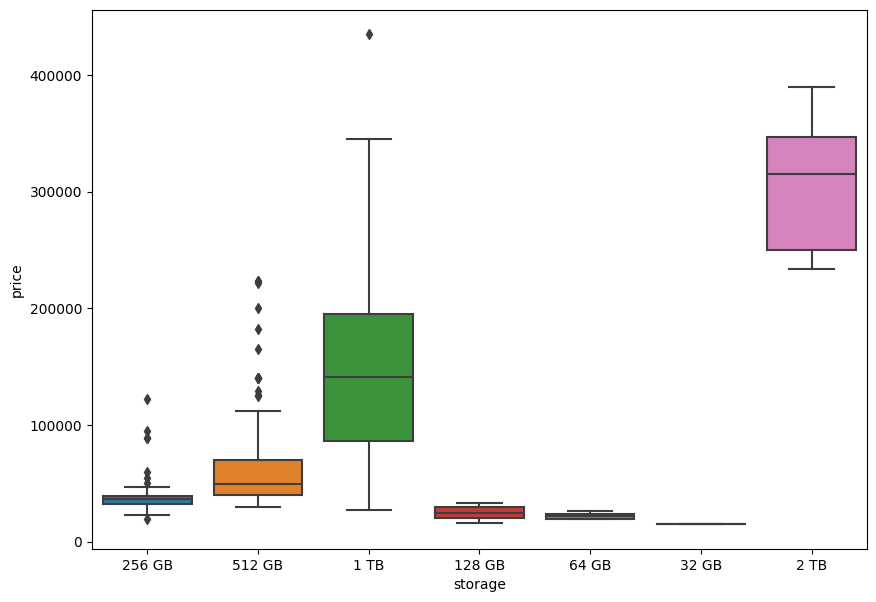

In [20]:
# plt.figure(figsize=(10, 7))
# sns.boxplot(x = df.storage, y = df.price);

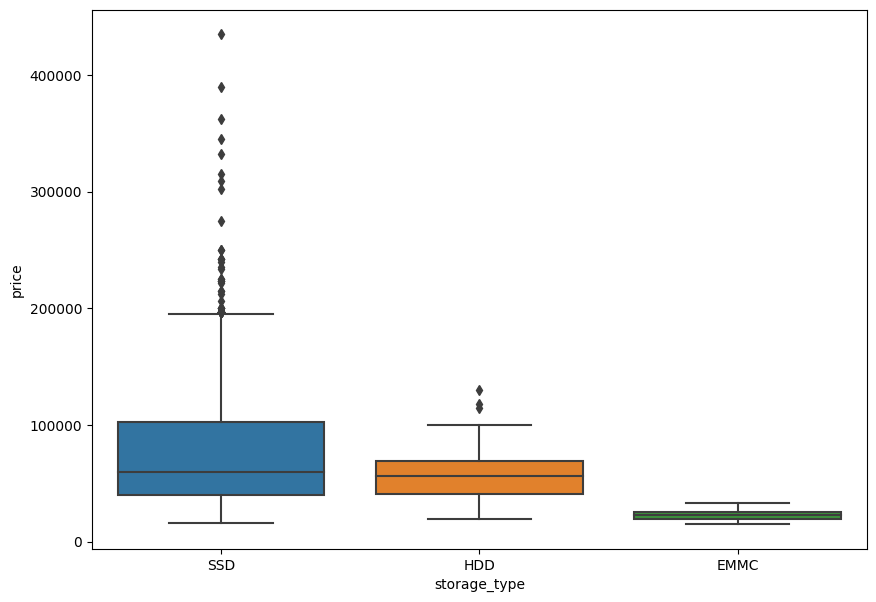

In [21]:
# plt.figure(figsize=(10, 7))
# sns.boxplot(x = df.storage_type, y = df.price);

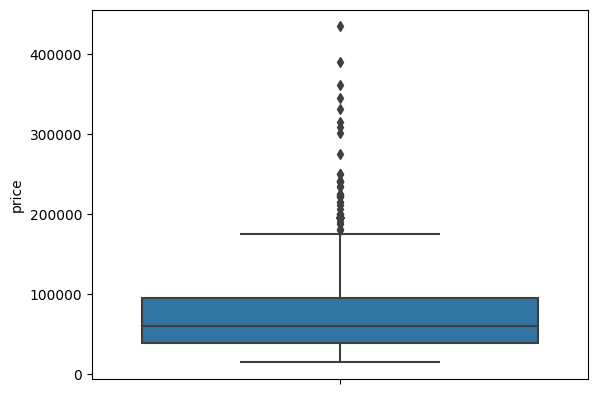

In [22]:
# sns.boxplot(y=df["price"]);

In [13]:
df['ram_size'] = df['ram_size'].str.extract('(\d+)').astype(int)

In [24]:
# df.head(3)

,price,ram_size,ram_type,processor,storage,os,display,storage_type
0,36990.0,8,DDR4,Intel Core i3 Processor,256 GB,Windows 11,35.56 cm (14 inch,SSD
1,39990.0,8,DDR4,Intel Core i3 Processor,512 GB,Windows 11,39.62 cm (15.6 inch,SSD
2,32990.0,8,DDR4,Intel Core i3 Processor,512 GB,Windows 11,39.62 cm (15.6 inch,SSD


In [25]:
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         720 non-null    float64
 1   ram_size      720 non-null    int32  
 2   ram_type      720 non-null    object 
 3   processor     720 non-null    object 
 4   storage       720 non-null    object 
 5   os            720 non-null    object 
 6   display       720 non-null    object 
 7   storage_type  720 non-null    object 
dtypes: float64(1), int32(1), object(6)
memory usage: 42.3+ KB


In [14]:
df['display'] = df['display'].apply(lambda x: float(re.findall("\d+\.\d+|\d+", x)[0]))

In [15]:
dict_ram_type = {'LPDDR3':0, 'Unified Memory':1, 'LPDDR4':2,'DDR4':3, 'LPDDR4X':4, 'LPDDR5':5, 'DDR5':6}
dict_processor = {'AMD Athlon Dual Core Processor':0, 
                  'AMD Dual Core Processor':1, 
                  'Intel Celeron Dual Core Processor':2, 
                  'Intel Celeron Quad Core Processor':3, 
                  'Intel Pentium Quad Core Processor':4, 
                  'Intel Pentium Silver Processor':5, 
                  'AMD Ryzen 3 Dual Core Processor':6, 
                  'AMD Ryzen 3 Quad Core Processor':7, 
                  'AMD Ryzen 3 Hexa Core Processor':8, 
                  'AMD Ryzen 5 Dual Core Processor':9, 
                  'AMD Ryzen 5 Quad Core Processor':10, 
                  'AMD Ryzen 5 Hexa Core Processor':11, 
                  'AMD Ryzen 7 Quad Core Processor':12, 
                  'AMD Ryzen 7 Octa Core Processor':13, 
                  'AMD Ryzen 9 Octa Core Processor':14, 
                  'Apple M1 Processor':15, 
                  'Apple M1 Pro Processor':16, 
                  'Apple M1 Max Processor':17, 
                  'Apple M2 Processor':18, 
                  'Intel Core i3 Processor':19, 
                  'Intel OptaneIntel Core i3 Processor':20, 
                  'Intel Core i5 Processor':21, 
                  'Intel Evo Core i5 Processor':22, 
                  'Intel Core i7 Processor':23, 
                  'Intel Core i9 Processor':24, 
                  'Qualcomm Snapdragon 7c Gen 2 Processor':25}
dict_storage = {'32 GB':0, '64 GB':1, '128 GB':2, '256 GB':3, '512 GB':4, '1 TB':5, '2 TB':6}
dict_storage_type = {'EMMC':0, 'HDD':1, 'SSD':2}
dicts_cols = {'ram_type':dict_ram_type, 'processor':dict_processor, 'storage':dict_storage, 'storage_type': dict_storage_type}


In [16]:
le = LabelEncoder()

for col, col_dict in dicts_cols.items():
    df[col] = le.fit_transform(df[col].astype(str))

In [17]:
le = LabelEncoder()
df['os'] = le.fit_transform(df['os'])
os_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [20]:
df.storage_type.value_counts()

2    662
1     48
0     10
Name: storage_type, dtype: int64

In [30]:
# df.dtypes

price           float64
ram_size          int32
ram_type          int32
processor         int32
storage           int32
os                int32
display         float64
storage_type      int32
dtype: object

In [31]:
# skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 720    │ │ int32       │ 6     │                                                          │
│ │ Number of columns │ 8      │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %   ┃ mean     ┃ sd      ┃ p0      ┃ p25     ┃ p75     ┃ p100     ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ price             │    0 │      0 │    82000 │   62000 │   15000 │   39000 │   95000 │   430000 │   █▂▁    │  │
│ │ ram_size          │    0 │      0 │       12 │     8.1 │       4 │       8 │      16 │      130 │    █     │  │
│ │ ram_type          │    0 │      0 │     0.53 │     1.3 │       0 │       0 │       0 │        6 │  █▁  ▁   │  │
│ │ processor         │    0 │      0 │       13 │     5.6 │       0 │       8 │      18 │       25 │  ▁▄▂▁█   │  │
│ │ storage           │    0 │      0 │      3.1 │     2.2 │       0 │       0 │       5 │        6 │  ▅  ▂ █  │  │
│ │ os                │    0 │      0 │      3.7 │    0.64 │       0 │       4 │       4 │        4 │      ▂█  │  │
│ │ display           │    0 │      0 │       39 │     3.7 │      14 │      38 │      40 │       89 │    ▃█    │  │
│ │ storage_type      │    0 │      0 │      1.9 │    0.34 │       0 │       2 │       2 │        2 │     ▁ █  │  │
│ └───────────────────┴──────┴────────┴──────────┴─────────┴─────────┴─────────┴─────────┴──────────┴──────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

## Take a look closely at the target variable, that is our price

In [32]:
# print(f'The Mean Price is: {df.price.mean():.2f}')
# print('-----------------------------------------')

# print('The Median Price is:', df.price.median())
# print('******************************************')

# print(f'The Standard Deviation of Price is: {df.price.std():.2f}')
# print('------------------------------------------')

# print('The 90th Quantile Price is:', df.price.quantile(.90))
# print('******************************************')

# print('The Minimum Price is:', df.price.min())
# print('--------------------------------------------')

# print('The Maximum Price is:', df.price.max())
# print('******************************************')

The Mean Price is: 81605.84
-----------------------------------------
The Median Price is: 59990.0
******************************************
The Standard Deviation of Price is: 61552.96
------------------------------------------
The 90th Quantile Price is: 194990.0
******************************************
The Minimum Price is: 14990.0
--------------------------------------------
The Maximum Price is: 434830.0
******************************************


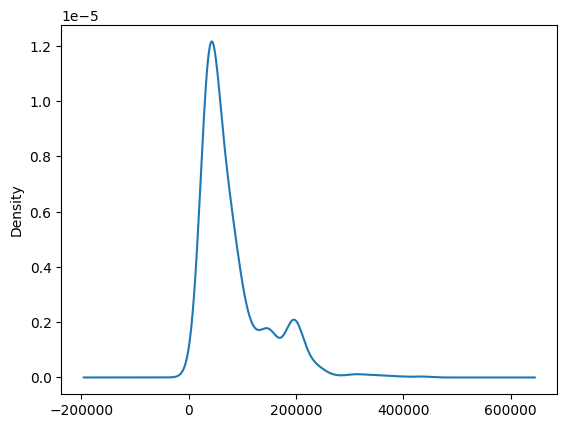

In [33]:
# df.price.plot(kind='kde');

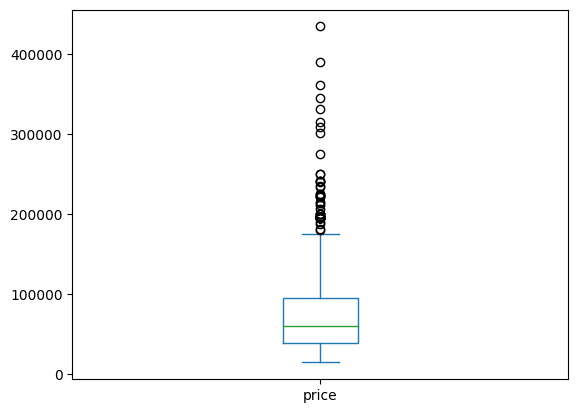

In [34]:
# df.price.plot(kind='box');

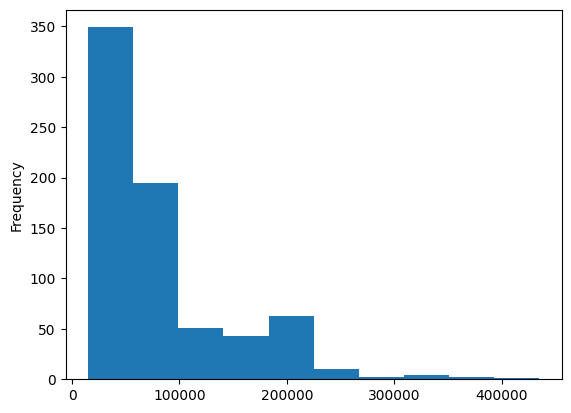

In [35]:
# df.price.plot(kind='hist');

We see that half of laptops are sold in the range of 5000 to 100000, relatively, people spend less than 3000000 on laptops while very few spend between 300000 and above

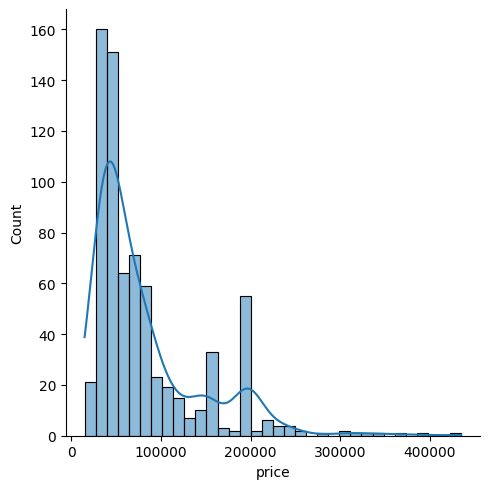

In [36]:
# sns.displot(df.price, kde = True);

In [37]:
X = df.drop('price', axis=1)
y = np.log(df['price'])

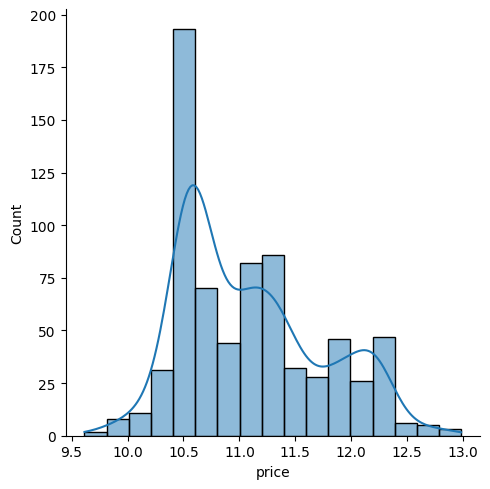

In [38]:
# sns.displot(y, kde = True);

#### split the dataset into 80% train set and 20% test set

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### We will use three models, Linear regression, Grandiant Boosting and Xgboost

In [40]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

models = {
    'Linear Regression': LinearRegression(),
    'Gbr': GradientBoostingRegressor(),
    'XGB': XGBRegressor()
}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    '''
    Fits and evaluates given machine learning models.
    models : a dictionary of different Scikit-Learn or XGBoost machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : testing labels
    '''
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Make predictions with the trained model
        y_pred = model.predict(X_test)
        # Calculate model evaluation metrics
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        # Add the model evaluation metrics to the model_scores dictionary
        model_scores[name] = {'R2_score': r2, 'MSE': mse, 'MAE': mae, 'RMSE': rmse}
    return model_scores


In [41]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)

# print(model_scores)

[10:15:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'Linear Regression': {'R2_score': 0.5242482148894944, 'MSE': 0.21618109525644727, 'MAE': 0.34286935064225926, 'RMSE': 0.4649527882016058}, 'Gbr': {'R2_score': 0.9388765296011099, 'MSE': 0.027774438667924003, 'MAE': 0.1203002594527346, 'RMSE': 0.16665664903604657}, 'XGB': {'R2_score': 0.930967238775686, 'MSE': 0.03136841184228581, 'MAE': 0.1318367283518075, 'RMSE': 0.17711129789566166}}


## Model Comparison

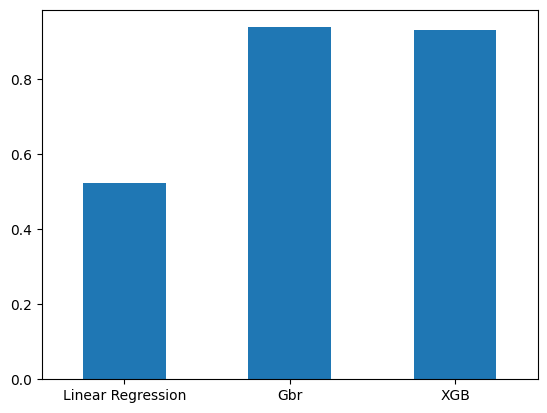

In [42]:
model_scores = {'Linear Regression': 0.5242482148894944,
                'Gbr': 0.9388765296011099,
                'XGB': 0.930967238775686}

# scores_series = pd.Series(model_scores)
# scores_series.plot.bar(rot=0);

## Hyperparameter Tuning

In [43]:
# # GridSearchCV for GradientBoostingRegressor
# Gbr_reg_grid = {'learning_rate': [0.05, 0.1, 0.15],
#                 'max_depth': [3, 4, 5],
#                 'min_samples_split': [2, 5, 10],
#                 'min_samples_leaf': [1, 2, 4],
#                 'max_features': [None, 'sqrt', 'log2'],
#                 'n_estimators': [100, 200, 300]}



# # Setup random seed
# np.random.seed(42)

# # Setup random hyperparameter search for GradientBoostingRegressor
# gbr_grid = GridSearchCV(GradientBoostingRegressor(), 
#                         param_grid = Gbr_reg_grid,
#                         cv=5,
#                         n_jobs=-1,
#                         verbose=True)

# # Fit random hyperparameter search model for GradientBoostingRegressor()
# gbr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [3, 4, 5],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=True)

In [44]:
# print(" Results from GridSearchCV " )
# print("\n The best parameters:\n", gbr_grid.best_params_)
# print("\n The best score:\n", gbr_grid.best_score_)

 Results from GridSearchCV 

 The best parameters:
 {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}

 The best score:
 0.9123022986623607


In [45]:
# GridModel = GradientBoostingRegressor(learning_rate=0.05, max_features='sqrt', max_depth=5, n_estimators=300, min_samples_split=10, min_samples_leaf = 2)
# GridModel.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, max_features='sqrt',
                          min_samples_leaf=2, min_samples_split=10,
                          n_estimators=300)

In [46]:
# y_pred_grid =GridModel.predict(X_test)

In [47]:
# evaluate the model
mse = mean_squared_error(y_test, y_pred_grid)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_grid)
mae = mean_absolute_error(y_test, y_pred_grid)

# print("MSE: ", mse)
# print("RMSE: ", rmse)
# print("R-squared: ", r2)

MSE:  0.02756120342281248
RMSE:  0.16601567222046382
R-squared:  0.9393457984258882


In [48]:
# # RandomizedSearchCV for GradientBoostingRegressor
# Gbr_reg_rs = {'learning_rate': [0.05, 0.1, 0.15],
#               'max_depth': [3, 4, 5],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4],
#               'max_features': [None, 'sqrt', 'log2'],
#               'n_estimators': [100, 200, 300]}



# # Setup random seed
# np.random.seed(42)

# # Setup random hyperparameter search for GradientBoostingRegressor
# gbr_rs = RandomizedSearchCV(GradientBoostingRegressor(), 
#                               param_distributions = Gbr_reg_rs,
#                               cv=5,
#                               n_jobs=-1,
#                               n_iter=20,
#                               verbose=True)

# # Fit random hyperparameter search model for GradientBoostingRegressor()
# gbr_rs.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15],
                                        'max_depth': [3, 4, 5],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   verbose=True)

In [49]:
# print(" Results from RandomSearchCV " )
# print("\n The best parameters:\n", gbr_rs.best_params_)
# print("\n The best score:\n", gbr_rs.best_score_)

 Results from RandomSearchCV 

 The best parameters:
 {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 3, 'learning_rate': 0.1}

 The best score:
 0.9084887453625716


In [50]:
rsModel = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=300,max_features=None, min_samples_split=5, min_samples_leaf=4)
rsModel.fit(X_train,y_train)

GradientBoostingRegressor(min_samples_leaf=4, min_samples_split=5,
                          n_estimators=300)

In [51]:
y_pred_rs = rsModel.predict(X_test)

In [52]:
# # evaluate the model
# mse = mean_squared_error(y_test, y_pred_rs)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred_rs)
# mae = mean_absolute_error(y_test, y_pred_rs)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("R-squared: ", r2)

MSE:  0.027390246863026053
RMSE:  0.16549999052273706
R-squared:  0.9397220241471903


In [54]:
# df.head()

,price,ram_size,ram_type,processor,storage,os,display,storage_type
0,36990.0,8,0,17,3,4,35.56,2
1,39990.0,8,0,17,5,4,39.62,2
2,32990.0,8,0,17,5,4,39.62,2
3,49990.0,8,0,6,5,3,39.62,2
4,49990.0,8,0,18,5,4,39.62,2


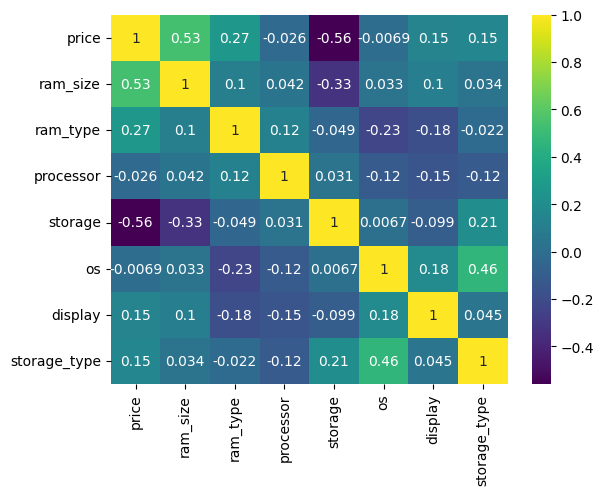

In [56]:
# # Compute the correlation matrix
# corr_matrix = df.corr()

# # Plot a heatmap of the correlation matrix
# sns.heatmap(corr_matrix, annot=True, cmap='viridis')

# # Show the plot
# plt.show()

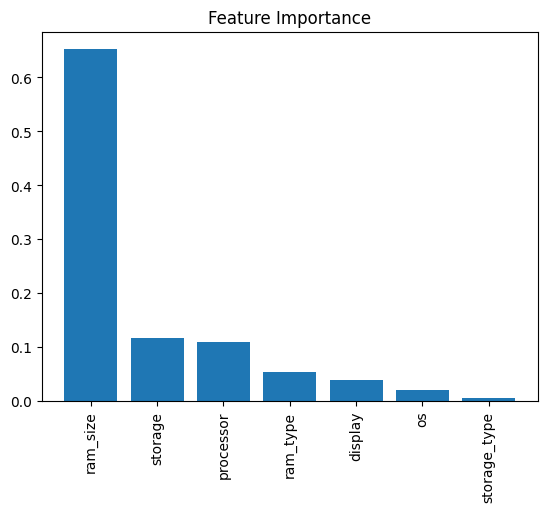

In [57]:
# # Get the feature importances
# feature_importances = rsModel.feature_importances_

# # Sort feature importances in descending order
# indices = np.argsort(feature_importances)[::-1]

# # Rearrange feature names so they match the sorted feature importances
# names = [X.columns[i] for i in indices]

# # Create plot
# plt.figure()

# # Create plot title
# plt.title("Feature Importance")

# # Add bars
# plt.bar(range(X.shape[1]), feature_importances[indices])

# # Add feature names as x-axis labels
# plt.xticks(range(X.shape[1]), names, rotation=90)

# # Show plot
# plt.show()

In [58]:
# df.to_csv("df.csv", index=False)

In [59]:
# joblib.dump(rsModel,'best_model.pkl')

['best_model.pkl']